CS244 Assignment 6 - Group 8
===============

* Kevin Rothi (leader)
* John Lanier
* J.Y. Ku

Github Repository 
https://github.com/JBLanier/cs244fall2017/ 



Signal Processing
----------------

Our team used Python for this project. The SciPy library has some great components for signal processing in the scipy.signal library. Applying these components to the signal provided in the correct way proved to be both a challenge and a learning experience.

### Filter Challenges

1. Selecting the correct filter type.
2. Selecting the correct cutoff frequencies.
3. Selecting the correct number of poles to use.
4. Applying the filter to the signal.

First, the filter type wasn't obvious. The team eventually went with a Butter bandpass filter for the heart rate and respiration rate calculations since these signals needed both the high and low frequencies filtered out, since the signal we wanted to isolate occupies a specific band of frequencies. For the SPO2 calculations, after exhaustive experimentation, the team eventually got the best results with a lowpass filter. We theorize that this is because the DC component is a very low frequency wave, and using a bandpass filter would remove it, but more investigation would be needed to confirm this completely.

Selecting the cutoff frequencies was generally the result of experimentation. Too much filtering would remove the peaks, resulting in sine wave like behaviour. This actually made peak detection easier, which this report will cover in the next section, but the tradeoff was that the smooth sine wave would lack detail pertaining to the heart rate which we wanted to keep (the wave would be too smooth).

The correct response curve (pole number) was also not immediately obvious. We eventually settled with a value of 4 since this seemed to give us the best result.

Applying the filter to the signal also proved to be an interesting exercise in signal processing. Using the signal, lfilter method would induce a frequency dependent phase shift to the signal. In the case of the breathing and respiration rate calculations, this wasn't necessarily a bad thing, but with the SPO2 calculation it was imperative that the signal remained in phase if we wanted to use the same peak and valley locations for both signals. We did experiment with working around the phase shift issue be finding the peaks and valleys for both the filtered signals, but this proved to be problematic and this approach was eventually abandoned in favor of using the signal.filtfilt method to apply the filter, which does not induce a phase shift. We also used [Gustafsson’s method](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.signal.filtfilt.html#r216) when applying the filter with filtfilt since we wanted to minimize the transient induced at the beginning of the signal.

Peak Detection
-------------

After the signals had been properly filtered, the next step was to perform peak detection with additional valley detection necessary for the SPO2 calculations. This proved to be as challenging as the filtering step since Python's primary methods for peak and valley detection didn't perform well in practice.

### Peak Detection Challenges

1. Selecting the correct order for signal.argrelextrema
2. Selecting the correct comparator function for signal.argrelextrema
3. Experimenting with peakutils
4. Eventually settling for a new approach (moving subsection of the signal)

SciPy's signal.argrelextrema and it's siblings argrelmax and argrelmin take an argument called "order" which controls how the function looks for peaks, comparing the values around a suspected point using the comparator function out to the value specified with order. The problem is that values of order that are too small would result in false positives, but values too large would miss peaks and valleys. Selecting the correct order proved to be very challenging since accurate peak detection 100% of the time was critical for success, especially in the case of the SPO2 calculations.

On the topic of the comparator function, the choices are the typical greater or less, but also greater_equal and less_equal. If the signal was dramatically filtered, the latter proved to be more effective at correctly finding peaks.

The team also experimented with the peakutils library, but this proved to exhibit the same challenges that were associated with the use of argrelextrema, specifically selecting parameters that were robust to noise and variations in the signal's periodicity.

The team eventually came up with a new method specifically for calculating the SPO2 levels. The entire signal was parcellated into sections by second. This allowed for a much more controlled peak/valley finding technique which would...

1. Do its best to find 2 valleys within a reasonable distance from each other.
2. Do its best to assure that the peak found was between the two valleys.

The code should largely speak for itself, but argrelextrema is called to find the valleys in the signal chunk. Then the peaks are found, and only the peak that landed between the two valleys is kept.

*This works well because it avoids the continuity problems associated with missed valleys and peaks when processing the signal as a whole.*

After we've found the appropriate peaks and valleys, the rest was fairly trivial. For the heart rate and respiration rate calculations, the formula to convert the time between peaks to a per minute rate was simple algebra. The SPO2 calculation was more involved.

### Calculating SPO2

First, we need to find the DC values for the both the IR and red signals. This is accomplished by finding two adjacent valleys and determining their actual values at those points. We then generate a line connecting the two points with numpy's interp function. We then find the peak between the two valleys, and ascertain the interpolated value where the peak is. This is the DC value. The AC value is simply the difference between the value at the peak and the DC value.

This was easily the most challenging part of the assignment. Applying the appropriate filtering and finding the peaks/valleys represented the bulk of the work done, but the final result seems satisfactory. 

### Final Notes

Something you might notice is that in our results we have the heart rate and respiration rate as peak to peak values. For SPO2, we have it broken down by second. This is a consequence of the two different methods we used to derive our results. The Heart Rate, Respiration Rate, and SPO2 values in each row of the csv do not correspond to the explicit time values on the same rows, nor do they correspond to each other in time.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import sklearn
np.random.seed(42)
%matplotlib inline

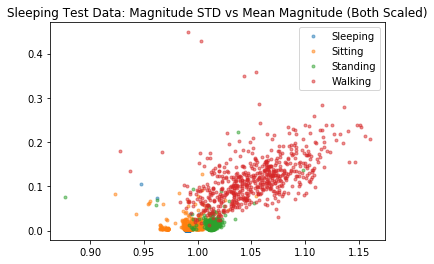

Cross Validation Accuracy: 0.8679166666666667
Test Error Rate on a 2nd 10 minute sleeping data set: 0.023333333333333317


In [2]:
def getGeneratedFeatureData(raw_data, window_size):
    gen_features = np.full(((len(raw_data)//window_size),3),-1.0)
    for window_num, window_start_index in enumerate(range(0,len(raw_data),window_size)):
        # Check for case in which last window isn't as large as desired window_size
        if (window_start_index + window_size) > len(raw_data):
            #print("Last window at {} was too small, excluding it.".format(window_start_index))
            break
        # Gather magnitudes of data points in window
        window_magnitudes = np.full(window_size,-1.0)
        for window_index, raw_data_index in enumerate(range(window_start_index, window_start_index + window_size)):
            magnitude = np.linalg.norm(raw_data[raw_data_index][-4:-1])
            window_magnitudes[window_index] = magnitude 
            #print("c: {} index: {} W: {} values: {} magnitude: {}".format(raw_data[raw_data_index,-1],raw_data_index,window_num,raw_data[raw_data_index][:-1],magnitude))
       
        #print("Window:\n{}".format(window_magnitudes))
        #print("Mean: {} Std: {}".format(window_magnitudes.mean(),window_magnitudes.std()))
        gen_features[window_num,0] = window_magnitudes.mean()
        gen_features[window_num,1] = window_magnitudes.std()
        gen_features[window_num,2] = raw_data[0,-1]
    return gen_features

# Pull in Raw Training Data
tr_sleeping = np.genfromtxt('sleeping.csv', delimiter=',')[1:]
tr_sitting = np.genfromtxt('sitting.csv', delimiter=',')[1:]
tr_standing = np.genfromtxt('standing.csv', delimiter=',')[1:]
tr_walking = np.genfromtxt('walking.csv', delimiter=',')[1:]

# Add Class Labels
tr_sleeping = np.concatenate((tr_sleeping,np.full((len(tr_sleeping),1),1)),axis=1)
tr_sitting  = np.concatenate((tr_sitting ,np.full((len(tr_sitting) ,1),2)),axis=1)
tr_standing = np.concatenate((tr_standing,np.full((len(tr_standing),1),3)),axis=1)
tr_walking  = np.concatenate((tr_walking ,np.full((len(tr_walking) ,1),4)),axis=1)

# Trim out all but xyz and class data
tr_sleeping = tr_sleeping[:,-4:]
tr_sitting = tr_sitting[:,-4:]
tr_standing = tr_standing[:,-4:]
tr_walking = tr_walking[:,-4:]

# Generate our Final Training Data from windows of raw data (std magnitude and mean magnitude only)
window_size = 50
tr_sleeping = getGeneratedFeatureData(tr_sleeping,window_size)
tr_sitting = getGeneratedFeatureData(tr_sitting,window_size)
tr_standing = getGeneratedFeatureData(tr_standing,window_size)
tr_walking = getGeneratedFeatureData(tr_walking,window_size)

# Put Training data in one np array
train = np.concatenate((tr_sleeping,tr_sitting,tr_standing,tr_walking))

tr_X = train[:,:-1]
tr_Y = train[:,-1]

scaler = StandardScaler()
scaler.fit(tr_X)
tr_X = scaler.transform(tr_X)

# Plot
df = pd.DataFrame(train)
df.columns = ['Mean', 'STD', 'Class']
groups = df.groupby('Class')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for group, label in zip(groups,['Sleeping','Sitting','Standing','Walking']):
    group = group[1]
    ax.plot(group.Mean, group.STD, marker='o', alpha = 0.5, linestyle='', ms=3, label=label)
ax.legend()
plt.title("Sleeping Test Data: Magnitude STD vs Mean Magnitude (Both Scaled)")
plt.show()

clf = svm.SVC()
scores = cross_val_score(clf, tr_X, tr_Y, cv=5)
print('Cross Validation Accuracy: {}'.format(np.mean(scores)))

clf.fit(tr_X,tr_Y)

test_sleeping = np.genfromtxt('sleeping2.csv', delimiter=',')[1:]
test_sleeping = np.concatenate((test_sleeping,np.full((len(test_sleeping),1),1)),axis=1)
test_sleeping = test_sleeping[:,-4:]
test_sleeping = getGeneratedFeatureData(test_sleeping,window_size)
test_sleeping_X = test_sleeping
test_X = test_sleeping[:,:-1]
test_X = scaler.transform(test_X)
test_Y = test_sleeping[:,-1]

test_accuracy = sklearn.metrics.accuracy_score(test_Y,clf.predict(test_X))
test_error_rate = 1.0 - test_accuracy

print("Test Error Rate on a 2nd 10 minute sleeping data set: {}".format(test_error_rate))


In [3]:
def getRatio(acRed, dcIR, acIR, dcRed):
    return float(acRed * dcIR) / (acIR * dcRed)

def calculateSPO2(R):
    return (-45.060 * math.pow(R, 2)) + (30.354 * R) + 94.845

def generateWindow(index, window_size_seconds, Fs):
    return index, index + (window_size_seconds * int(Fs))

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, [high], btype='low')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

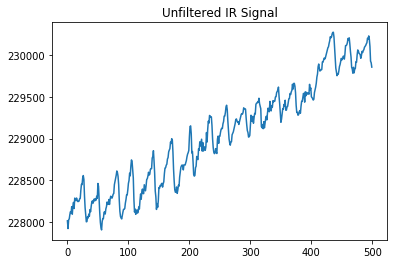

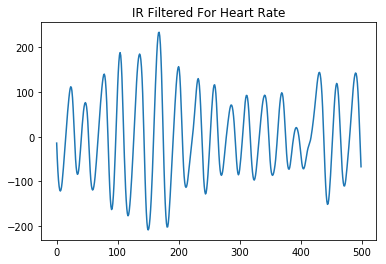

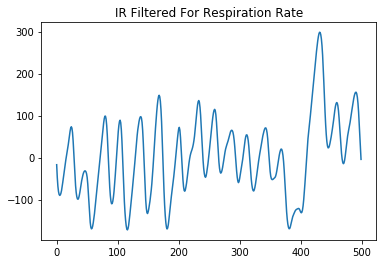

In [4]:
sensor_data = np.genfromtxt('sleeping2.csv', delimiter=',')[1:] #pull in the data from the csv (generates matrix)

time = np.array(sensor_data[:,0]) #use the function we came up with earlier to pull out the columns for time, ir, red
time = time - time.min()

ir = sensor_data[:,1]
red = sensor_data[:,2]

Fs = len(time)/((time.max() - time.min())/1000) # Sampling Rate in Hz
Ts = 1.0/Fs # sampling interval

#Cutoff frequencies in Hz
heart_rate_lowcut = 0.8
heart_rate_highcut = 1.8

respiration_lowcut = 0.2
respiration_highcut = 1.5

#filter data
filtered_heart_rate_ir = butter_bandpass_filter(ir, heart_rate_lowcut, heart_rate_highcut, Fs, order=1)
filtered_respiration_ir = butter_bandpass_filter(ir, respiration_lowcut, respiration_highcut, Fs, order=1)

plt.plot(ir[50:550])
plt.title("Unfiltered IR Signal")
plt.show()

plt.plot(filtered_heart_rate_ir[50:550])
plt.title("IR Filtered For Heart Rate")
plt.show()

plt.plot(filtered_respiration_ir[50:550])
plt.title("IR Filtered For Respiration Rate")
plt.show()

In [5]:
hrPeaks = signal.argrelextrema(filtered_heart_rate_ir, np.greater_equal, order=30)[0] 
rrPeaks = signal.argrelextrema(filtered_respiration_ir, np.greater_equal, order=100)[0]

hr_window_size = 10
heartRates = np.zeros(len(hrPeaks))
heartRateTimeStampes = np.zeros(len(hrPeaks)//hr_window_size)
print('---------- HR VALUES -----------')
heartRates = np.zeros(len(hrPeaks))
for peakIndex in range(len(hrPeaks) - 1):
    if (peakIndex % hr_window_size) == 0 and peakIndex + hr_window_size < len(hrPeaks):
        heartRateTimeStampes[peakIndex//hr_window_size] = time[hrPeaks[peakIndex]]
        
    distance = time[hrPeaks[peakIndex + 1]] - time[hrPeaks[peakIndex]]
    heartRates[peakIndex] = (60000 / distance)
if not len(heartRates) % hr_window_size == 0:
    heartRates = heartRates[:-(len(heartRates) % hr_window_size)]
heartRates = np.mean(heartRates.reshape(-1, hr_window_size),axis=1)
for r in heartRates:
    print(r)
print('Mean: {}'.format(np.array(heartRates).mean()))
print('---------- END HR VALUES ---------------')


rr_window_size = 10
rRates = np.zeros(len(rrPeaks))
rRateTimeStampes = np.zeros(len(rrPeaks)//rr_window_size)
print('---------- RR VALUES -----------')
for peakIndex in range(len(rrPeaks) - 1):
    if (peakIndex % rr_window_size) == 0 and peakIndex + rr_window_size < len(rrPeaks):
        rRateTimeStampes[peakIndex//rr_window_size] = time[rrPeaks[peakIndex]]
    
    distance = time[rrPeaks[peakIndex + 1]] - time[rrPeaks[peakIndex]]
    rRates[peakIndex] = (60000 / distance)
if not len(rRates) % rr_window_size == 0:
    rRates = rRates[:-(len(rRates) % rr_window_size)]
rRates = np.mean(rRates.reshape(-1, rr_window_size),axis=1)
for r in rRates:
    print(r)
print('Mean: {}'.format(np.array(rRates).mean()))
print('---------- END RR VALUES ---------------')

---------- HR VALUES -----------
44.4835658303
39.9220904904
67.3246940833
51.8912162514
61.2081087138
70.1958083933
62.9736216615
71.3971246613
60.6645492112
62.5027392655
66.4288855729
64.8926312119
68.6575853423
61.9675734689
55.9475665961
61.6085641801
58.0455275437
67.2440849837
53.0669474086
62.8048991845
46.2767561446
50.9936110099
58.0510208933
53.3898595663
60.1185055355
62.6619017949
64.1314201237
62.5152731562
51.3603831737
55.8194416301
64.1263678203
62.704611139
62.8824686058
68.2785472643
63.3180135237
55.9718600239
58.5670011041
56.9598333259
59.0345604847
66.0372121217
55.5541585802
58.9222124298
61.2270880682
52.3523084198
60.0184653176
50.9114293906
53.5931226276
47.3409549717
53.042491339
57.2635007832
61.9276736649
48.297817363
55.9872982222
55.2261519024
39.7247508734
43.2731561203
Mean: 58.05516093874894
---------- END HR VALUES ---------------
---------- RR VALUES -----------
14.389421515
15.9560232499
16.071026909
15.8395705619
13.0044682099
15.2961993534
16.269

In [6]:

#--------------------
#---- SPO2 Calc -----
#--------------------

spo2_window_size_seconds = 3

ir_spo2 = np.reshape(ir, len(ir))
red_spo2 = np.reshape(red, len(red))  # shape them

b, a = signal.butter(4, 0.8, btype='lowpass') #filter for SPO2, just removing hf noise
filtIR = signal.filtfilt(b, a, ir_spo2, method='gust') #using filtfilt to avoid phase shift
filtRed = signal.filtfilt(b, a, red_spo2, method='gust') 

redDC = [] # need relevant arrays
redAC = []
irDC = []
irAC = []
spo2_timestamps = []

index = 0
while True:
    lb, ub = generateWindow(index, spo2_window_size_seconds, Fs) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
    if (ub > len(ir)):
        break
    redSlice = filtRed[lb:ub]
    irSlice = filtIR[lb:ub] #filtered data
    valleys = signal.argrelmin(redSlice, order=10)[0] #find peaks and valleys
    peaks = signal.argrelmax(redSlice, order=10)[0]
    valley1 = valleys[0] + lb
    valley2 = valleys[1] + lb
    peak = peaks[0] + lb
    if (peak < valley1): #to make sure the peak is between the valleys
        peak = peaks[1] + lb
    dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
    dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
    testSPO2 = calculateSPO2(getRatio(filtRed[peak] - dcred, dcir, filtIR[peak] - dcir, dcred))
    if testSPO2 < 96.0 or testSPO2 > 99.9: # garbage value? let's try searching for peaks dynamically
        attempts = 0
        while (testSPO2 < 96.0 or testSPO2 > 99.9) and attempts < 14 : # try orders from 6 - 19
            valleys = signal.argrelmin(redSlice, order=6 + attempts)[0] #find peaks and valleys
            peaks = signal.argrelmax(redSlice, order=6 + attempts)[0]
            if (len(valleys) < 2 or len(peaks) < 2):
                break; # no peaks or valleys?
            valley1 = valleys[0] + lb
            valley2 = valleys[1] + lb
            peak = peaks[0] + lb
            if (peak < valley1): #to make sure the peak is between the valleys
                peak = peaks[1] + lb
            dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
            dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
            attempts = attempts + 1
    irDC += [dcir]
    irAC += [filtIR[peak] - dcir]
    redDC += [dcred]
    redAC += [filtRed[peak] - dcred]
    spo2_timestamps.append(time[index])
    
    index = ub
        
    
print('---------- SPO2 VALUES -----------')
spo2s = []
for iteration in range(len(redDC)):
    spo2s.append(calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration])))
    print(calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration])))
print('Mean: {}'.format(np.array(spo2s).mean()))
print('---------- END SPO2 VALUES -----------')


---------- SPO2 VALUES -----------
97.2695659738
93.7212539843
96.4132611682
90.7391020359
96.2433678428
90.2595996
91.1944005731
92.9487180072
95.2502398404
94.9234389935
92.6370267036
96.3284696692
96.2418086307
97.8410129002
91.156898487
96.6350274654
96.8720741699
96.8534587711
93.0683247678
98.2947749367
96.3085387726
90.4000576593
99.2091056211
97.3146920459
98.7162958155
91.5347295897
97.7415283948
96.1673053121
97.76993573
97.5587827249
98.7396405959
98.0900937114
97.0488485116
97.5473525817
98.5876397363
95.7740905087
96.1327925234
94.0489448103
96.2863979682
97.7132044122
97.1040129159
96.8879263371
97.7514321995
98.0816030122
95.7171278004
96.0543184654
93.43817513
98.2858742449
98.2078082452
98.2265500437
94.815456152
96.9742323259
98.0609797509
97.9597170882
95.7168736562
96.4716186547
99.0430372889
95.8890165573
95.7322556288
93.0075065369
97.4244446089
93.4833840694
97.0250450145
94.9732927833
93.9577583548
97.9661251223
98.7315243612
97.1809329284
95.9469688386
97.32156

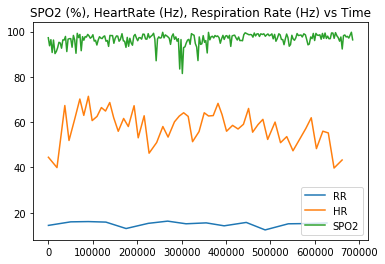

In [7]:
plt.plot(rRateTimeStampes,rRates,label="RR")
plt.plot(heartRateTimeStampes,heartRates,label="HR")
plt.plot(spo2_timestamps, spo2s,label="SPO2")
plt.legend()
plt.title("SPO2 (%), HeartRate (Hz), Respiration Rate (Hz) vs Time")
plt.show()

In [8]:
d = {'IR': pd.Series(ir),
     'RED': pd.Series(red),
     'X': pd.Series(sensor_data[:,3]),
     'Y': pd.Series(sensor_data[:,4]),
     'Z': pd.Series(sensor_data[:,5]),
     'HR': pd.Series(heartRates),
     'RR': pd.Series(rRates),
     'SPO2': pd.Series(spo2s),
     'Error Rate': pd.Series(test_error_rate)
    }

export_df = pd.DataFrame(d)
export_df = export_df[['IR','RED','X','Y','Z','HR','RR','SPO2','Error Rate']]

export_df.to_csv('team8_assignment6.csv', index=False)
